## __1-    MNIST:__

First we download the Mnist dataset. It can be download from using the fetch_openml.
This dataset contains data of 70,000 images of handwritten numbers from 0-9.
It contains images of 28x28 pixels == 784 pixels data and their labels.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", as_frame=False)

Mnist dataset contains already shuffled data for train and test set. First 60,000 rows are for training and last 10,000 rows are for testing.
.data is a 2D array of pixels while .target is a 1D array of labels(class) to which the pixels belongs.

In [3]:
pixels_data, labels_data = mnist.data, mnist.target

In [4]:
pixels_data.shape

(70000, 784)

In [5]:
labels_data.shape

(70000,)

In [6]:
pixels_train_data, pixels_test_data, labels_train_data, labels_test_data = pixels_data[:60000], pixels_data[60000:], labels_data[:60000], labels_data[60000:]

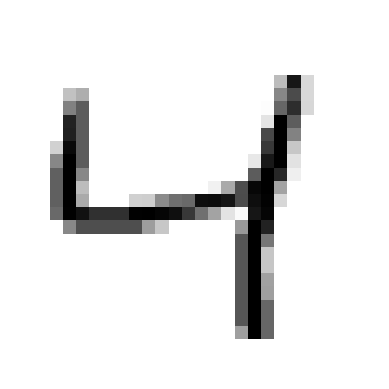

In [7]:
import matplotlib.pyplot as plt

# Creating a function to plot image from pixels data
def plot_digit(image_data):
    # changing 1D array into a 2D array of 28x28
    image_pixels = image_data.reshape(28 ,28)
    # .imshow is used to plot 2D pixels , cmap is used to set the color range ,
    #        "binary" set the color map to grayscale (0-255)
    plt.imshow(image_pixels, cmap="binary")
    plt.axis("off")

some_digit = pixels_data[2]
plot_digit(some_digit)
plt.show()

## __2-    Training a Binary Classifier:__

Binary classifier classifies a data between two possible conditions either (1)True or (0)False.
One such binary classifier is (stochastic Gradient Descent)SGDClassifier.
But binary classifier needs boolen labels to work. So we will convert first check if a number is 4 or not. 



In [8]:
labels_train_data_4 = (labels_train_data == '4')
labels_test_data_4 = (labels_test_data == '4')

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(pixels_train_data, labels_train_data_4)
sgd_clf.predict([some_digit])

array([ True])

## __3-    Performance Measures:__

we can measure the performance using cross_validation.

But accuracy is not a good strategy to measure performance as it can be misleading when one
class is more common than the other like there are more not-4 class then true-4.
so the accuracy will be biased towards the not-4 class.


In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, pixels_train_data, labels_train_data_4, cv=3, scoring="accuracy", n_jobs=-1)

array([0.9671 , 0.97645, 0.9687 ])

In [11]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(pixels_train_data, labels_train_data_4)

# It confirmms that the dummy classifier does not do any analysis it just classified every
#    image in the most frequent class i.e., not 4s
print(any(dummy_clf.predict(pixels_data)))

False


In [12]:
cross_val_score(dummy_clf, pixels_train_data, labels_train_data_4, cv=3, scoring="accuracy")

array([0.90265, 0.90265, 0.9026 ])

### - Implementing Cross Validation:

cross validation can also be implemented to get more control over the folds

In [13]:
# StratifiedKFold is used to make n validation sets from the data.
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

# .split in scikit learn validation tools , always returns indexes
# this loop will run three time 
for train_indexes , test_indexes in skfolds.split(pixels_train_data, labels_train_data_4):
    clone_clf = clone(sgd_clf) # creating clone of sgd_clf which is already trained
    pixels_train_folds = pixels_train_data[train_indexes]  # train folds (n_splits-1) each time
    labels_train_folds = labels_train_data_4[train_indexes]
    pixels_test_folds = pixels_train_data[test_indexes]  # test fold 1 each run
    labels_test_folds = labels_train_data_4[test_indexes]

    clone_clf.fit(pixels_train_folds, labels_train_folds)
    predicted_labels = clone_clf.predict(pixels_test_folds)
    correct_pred_labels = sum(predicted_labels == labels_test_folds) # total number of correct predictions
    accuracy = correct_pred_labels / len(predicted_labels) # accuracy of correctly predicting
    print(accuracy)
    



0.9671
0.97645
0.9687


## __4-    Confusion Matrices:__

It can be understood as a table that shows how many predictions our model make right or wrong and what kind of mistakes it made in prediction.

In [14]:
# First we need predicted data from the model to compare it against the actual values
from sklearn.model_selection import cross_val_predict
predicted_sgd_labels = cross_val_predict(sgd_clf, pixels_train_data, labels_train_data_4, cv=3)

# import the confusion matrix to use it 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_train_data_4, predicted_sgd_labels)

cm

array([[52957,  1201],
       [  554,  5288]], dtype=int64)

In the above 2D array the rows represents the actual class while the columns represent the predicted class.

Here the, 
(52957-True Negatives) - actual non 4 values which the model correctly predicted as not-4.
(1201-False Positives) - Those 4 values which the model incorrectly predicted as not-4.
(554-False Negatives) - Those non 4 values which the model incorrectly predicted as a 4.
(5288-True Positives) - Those 4 values which the model correctly predicted as a 4.

In [15]:
# How does perfect predictions looks like
perfect_cm =  confusion_matrix(labels_train_data_4, labels_train_data_4)

perfect_cm

array([[54158,     0],
       [    0,  5842]], dtype=int64)

## __5- Precision and Recall__

$Precision$ : It is the ratio of correctly positive predicted values(predicted values which were actually 4) to the total positive predicted values(all values predicted as a 4).

It tell us out of all positive predictions how many was actually correct.

$$
Precision = \frac{TP}{TP + FP}
$$

$Recall$  : It is the ratio of correctly positive predicted values(predicted values which are actually 4) to the total actual postive values(all values which are 4).

It tells us out of total positive values how many did the model catched.

$$
Recall = \frac{TP}{TP + FN}
$$

In [16]:
from sklearn.metrics import precision_score, recall_score

# we passed two inputs tot he scoring function first the actual labels and then the predicted labels
precision_score(labels_train_data_4, predicted_sgd_labels)

0.8149175527816305

In [17]:
recall_score(labels_train_data_4, predicted_sgd_labels)

0.905169462512838

$f1 score$ : f1_score is based on the harmonic mean of both precision and recall. It gives more weight to low values and high f1_score is obtained when both are high.

It is used to measure performance where both precision and recall matters

$$
F_1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$


In [18]:
from sklearn.metrics import f1_score

f1_score(labels_train_data_4, predicted_sgd_labels)

0.8576757764982564

## __6-    The Precision/Recall Trade-off__

How does the SGDClassifier makes its predictions?

- It uses a decision function which gives a score and if that score is higher then the threshold value(cut off value) then it assigns the instance to the positive class.
And the instance which have the highest score will be predicted.

- The threshold value is not chageable directly. 
It is 0 for predict and 0.5 for predict_proba.


In [19]:
# The decision function gives decision score.
decision_score = sgd_clf.decision_function([some_digit])
decision_score

array([3214.66574913])

In [20]:
# Checking when threshold is 0
threshold = 0
predicted_some_digit = (decision_score > threshold)
predicted_some_digit

array([ True])

In [21]:
# setting threshold to 3500.
threshold = 3500
# the model only give prediction on values on which it is more confident then the threshold value.
predicted_some_digit = (decision_score > threshold)
# the decision score does not passed the threshold point , so it didn't predicted a 4
predicted_some_digit

array([False])

In [22]:
# Getting decision scores for the whole prediction instead of values

decision_scores_for_train_labels = cross_val_predict(sgd_clf, pixels_train_data, labels_train_data_4,
                                               cv=3, method="decision_function" )

$Precision Recall Curve$ : precision recall curve is the graph that shows the tradeoff between precision and recall for a classifier at every possible threshold value.

The thresholds it gives are nothing just the sorted array of unique elements of the decision_score_for_labels. 
Then for each thresholds precisions and recalls are calculated.

In [23]:
# Precision Recall Curve gives three arrays presions, recalls and thresholds
from sklearn.metrics import precision_recall_curve
precisions, recalls , thresholds = precision_recall_curve(labels_train_data_4, decision_scores_for_train_labels)

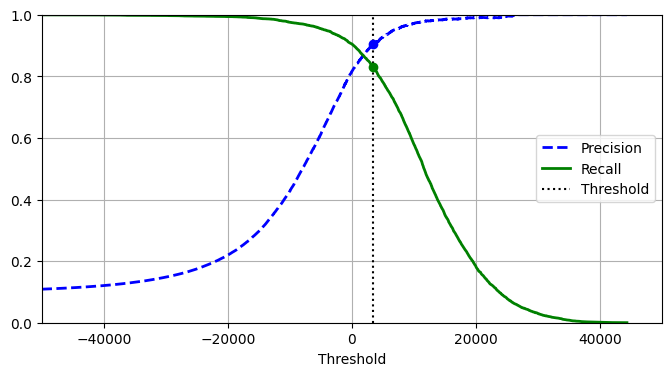

In [24]:
plt.figure(figsize=(8, 4)) # set the figure size
# Plot precisions against thresholds with blue dashed line
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
# Plot recalls against thresholds with green line
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
# plot a dotted line at thresholds between 0-1.0
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="Threshold")

# get the index of first thresholds greater than a threshold
idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

# def save_fig(fig_id):
#     path = os.path.join("images", fig_id + ".png")
#     plt.savefig(path, format='png', dpi=300)

# save_fig("precision_recall_vs_threshold_plot")
plt.show()

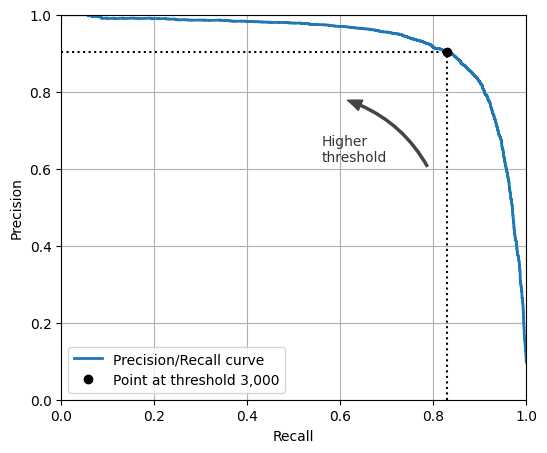

In [25]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

The above graphs shows that at a certain threshold where precision is 90 ,the recall is 83.

In [26]:
# get the first index where 90 precision is reached.
index_for_90_precision = (precisions >= 0.90).argmax()
# because the thresholds are in soreted order so the index at which precision is 90 will
#     be the smallest index for threshold at which precision is 90.
threshold_for_90_precision = thresholds[index_for_90_precision]
threshold_for_90_precision

3196.992969466491

In [27]:
# Create a boolean array of values greater than or equal to the 
#     minimum threshold value for 90 precision.
decision_scores_for_train_labels_prec_90 = (decision_scores_for_train_labels >= threshold_for_90_precision)

In [28]:
precision_score(labels_train_data_4, decision_scores_for_train_labels_prec_90)

0.9001287474710318

In [29]:
# The recall at precision 90
recall_at_90_precision = recall_score(labels_train_data_4, decision_scores_for_train_labels_prec_90)
recall_at_90_precision 

0.8377268058883944

## __7- The ROC Curve__

ROC(receiver operator characteristic) is used to plot graph between Recall(True negative Rate) and Fall-out(false positive rate)

$Recall$ : It tells us out of all positive values how many were model catched.

$Fall-out$ : It is the ratio of false positive predicted values to the total negative values.

It tells us out of all negative values how many were incorrectly predicted as positive.
$$
Fallout = \frac{FP}{FP + TN}
$$

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(labels_train_data_4, decision_scores_for_train_labels)

# the roc_curve do not initially give any method to get the threshold with high precision, so
#    we can fetch the index of the threshold at 90 precison from the precision_recall curve.
index_for_threshold_with_90prec = (thresholds <= threshold_for_90_precision).argmax()

# Now we can get the (TPR)recall and (FPR)fall-out values at which the precision is 90.
tpr_90, fpr_90 = tpr[index_for_threshold_with_90prec], fpr[index_for_threshold_with_90prec]

# ***We need those 90 precisiion values to check what might be the threshold, tpr ,fpr at 90 precision.

$Important$ :  the precision recall curve gives thresholds in ascending order(from low to high value) , while the roc curve gives them in descending order(from high value to low).
So the logic we used is from the one we used for roc curve
"index_for_threshold_with_90prec = (thresholds <= threshold_for_90_precision).argmax()".

If we had used "index_for_threshold_with_90prec = (thresholds >= threshold_for_90_precision).argmax()" then the first and highest value threshold index will come out and our precision and recall will become near to zero,you can try and see it in the roc graph.

__What does the ROC curve tells us?__

- "The ROC curve shows how the model’s ability to correctly identify positives (Recall) and its tendency to mistakenly classify negatives as positives (Fall-out) changes as we adjust the decision threshold.

- It is like, at certain threshold value the model may have high recall(TPR) but it might be incorrectly predicting many negatives(not - 4) as positives(4) i.e, the model also have high fall-out(FPR). We might not want this so we
plot the ROC curve to see at which threshold we can get good balance.

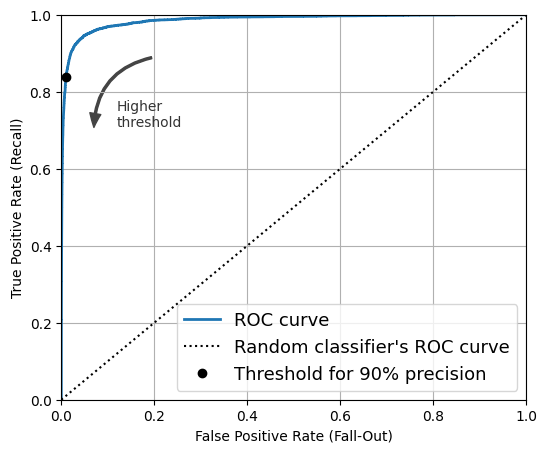

In [31]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
# save_fig("roc_curve_plot")

plt.show()

The above graph tells that at a certain threshold ,where the precision is 90(not shown), the recall is 83 and fallout is near to zero.

### __ROC_AUC_SCORE__ : 
- this score tells us how well a model can distinguish between positives and negatives. its range is from (0-1). 

- It is called area under the curve.

In [32]:
from sklearn.metrics import roc_auc_score

# It takes the true labels and predicted decision scores as input
roc_auc_score(labels_train_data_4, decision_scores_for_train_labels)

# --Why we didn't used decision_scores_for_train_labels_with_90prec?

0.9859276923382874

In [33]:
# Now we will see another classifier and compare which is better. and we will choose the better one.

from sklearn.ensemble import RandomForestClassifier

# The randomforestclassifier doesn't have a decision_function to give scores 
forest_clf = RandomForestClassifier(random_state=42)

# So we will use its probability for positives as a score, we can get it by "predict_proba"method. 
#    it gives probability score for negative and positive class
labels_train_probas_forest = cross_val_predict(forest_clf, pixels_train_data, labels_train_data_4, cv=3, method="predict_proba" )

In [34]:
labels_train_probas_forest[:2]  # it gives first two elements of the probability scores, 
#    the row represent total score for a prediction and columns represent score for negative and positive.

array([[1., 0.],
       [1., 0.]])

In [35]:
# The precision recall curve only takes in input scores as 1D array.
labels_train_scores_forest = labels_train_probas_forest[: ,1] # this creates a 1d array of 1column

precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(labels_train_data_4, labels_train_scores_forest)

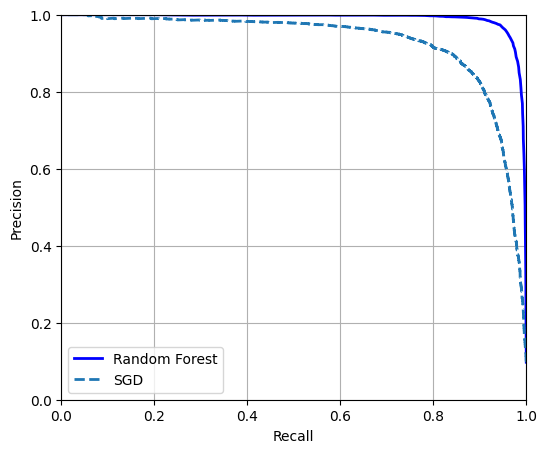

In [36]:
# Now we can compare the graphs of sgd_classifier and forest_classifier
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In the above grpah the area under curve(auc) is greater for random forest than SGD. 
So SGD is performing better here.

In [37]:
# It creates a new array having true for predictions when the positive probability is greater than 0.5.
labels_train_pred_forest = labels_train_probas_forest[:, 1] >= 0.5

f1_score(labels_train_data_4, labels_train_pred_forest)

0.9347452258122907

In [38]:
roc_auc_score(labels_train_data_4, labels_train_pred_forest)

0.9415749408273375

## __8- Multiclass Classification:__

Binary Classifiers can only distinguish between two classes.
So to work with multiple classes we can strategies like OvO , OvR.

In simple words, in multiclass classification Each input is assigned one label from more than two possible classes

__One-versus-rest or One-versus-all(OvA or OvR)__  : We create n number of classesifiers for n number of classes. like to classify if a number is 0 or not, 1 or not, .... 9 or not. and the classifier with highest decision score will win.

__One-versus-one(OvO)__ : We create n*(n-1)/2 number of classesifiers for n number of classes. like to classify if a number is 0 or 1, 0 or 2, .... 0-9, 1 or 2,.., 1 or 9. and the class most votes will win.



In [39]:
# Scikit learn automatically detects if we are trying to use multiclass classification on a binary 
#    classifier and it automatically apllies OvO or OVR strategy based on the algorithm.


# SVC is a binary classifier and here OvO strategy will be applied
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)

svm_clf.fit(pixels_train_data[:2000], labels_train_data[:2000])

svm_clf.predict([some_digit])

array(['4'], dtype=object)

In [40]:
# We can see the decision scores 
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)
# It does not give the scores for all 45 classifiers instead it gives the the scores
#    of "how confident the model is" for each class i.e., from 0-9.
# Here the model is most sure for 4th index which have class-4.

array([[ 1.76, -0.29,  7.23,  1.89,  9.3 ,  4.94,  3.84,  6.1 ,  1.75,
         8.19]])

In [41]:
class_id = some_digit_scores.argmax()
class_id

4

In [42]:
# we can see the classes label by
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [43]:
svm_clf.classes_[class_id]

'4'

In [44]:
# We can force scikit learn to use OneVsOne or OneVsRest classifier 
 
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))

ovr_clf.fit(pixels_train_data[:2000], labels_train_data[:2000])

ovr_clf.predict([some_digit])

array(['4'], dtype='<U1')

In [45]:
len(ovr_clf.estimators_)

10

In [46]:
# The SGDClassifier use OvR strategy internally if we pass it a multiclass array

sdg_clf = SGDClassifier(random_state=42)
sgd_clf.fit(pixels_train_data, labels_train_data)
sgd_clf.predict([some_digit])

array(['4'], dtype='<U1')

In [47]:
sgd_clf.decision_function([some_digit]).round()

array([[-34143., -21942.,  -4018.,  -2239.,     43., -15059., -33653.,
         -8278.,  -7461., -14180.]])

In [48]:
cross_val_score(sgd_clf, pixels_train_data, labels_train_data, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [54]:
# We can scale the values to get a better accuracy
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_pixels_train = scaler.fit_transform(pixels_train_data.astype("float64"))

cross_val_score(sgd_clf, scaled_pixels_train, labels_train_data, cv=3, scoring="accuracy",n_jobs=-1 )

array([0.8983, 0.891 , 0.9018])

## __9- Error Analysis:__

After selecting a model, we can see what type of errors it made through ConfusionMatrixDisplay.
The confusion matrix displays where the model is confused in classifying a digit. like how often it classifies a 4 as a 9.

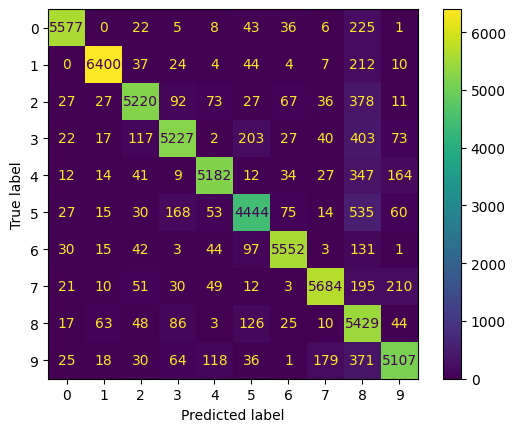

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay

# getting predicted labels to use it in confusion matrix display
labels_train_pred = cross_val_predict(sgd_clf, scaled_pixels_train, labels_train_data, cv=3, n_jobs=-1)

ConfusionMatrixDisplay.from_predictions(labels_train_data, labels_train_pred)
plt.show()

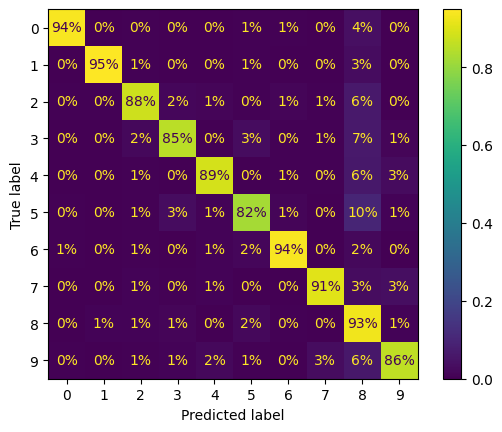

In [60]:
# By using normalize all the values are divided by the total predictions
# By using values_format=".0%", all values will be in percentage and non_decimal.
ConfusionMatrixDisplay.from_predictions(labels_train_data, labels_train_pred, 
                                        normalize="true", values_format=".0%")
plt.show()

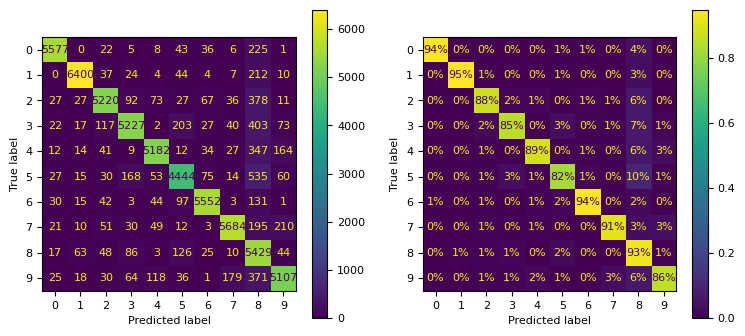

In [ ]:
# we can also splot both matrices 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=8)

ConfusionMatrixDisplay.from_predictions(labels_train_data, labels_train_pred, ax=axs[0])

ConfusionMatrixDisplay.from_predictions(labels_train_data, labels_train_pred, 
                                        normalize="true",ax=axs[1], values_format=".0%")
plt.show()
plt.rc('font', size=14)

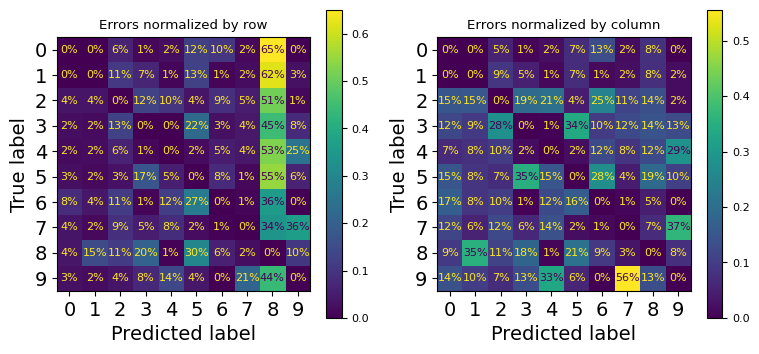

In [67]:
# we can add sample weight(different importance ) to each samples in the confusion matrix.
# Here we are adding weight to incorrect predictions only and ignoring the correct ones
sample_weight = (labels_train_data != labels_train_pred)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=8)
ConfusionMatrixDisplay.from_predictions(labels_train_data, labels_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(labels_train_data, labels_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
plt.show()
plt.rc('font', size=14)

In [68]:
cl_a, cl_b = '9', '4'
X_aa = pixels_train_data[(labels_train_data == cl_a) & (labels_train_pred == cl_a)]
X_ab = pixels_train_data[(labels_train_data == cl_a) & (labels_train_pred == cl_b)]
X_ba = pixels_train_data[(labels_train_data == cl_b) & (labels_train_pred == cl_a)]
X_bb = pixels_train_data[(labels_train_data == cl_b) & (labels_train_pred == cl_b)]

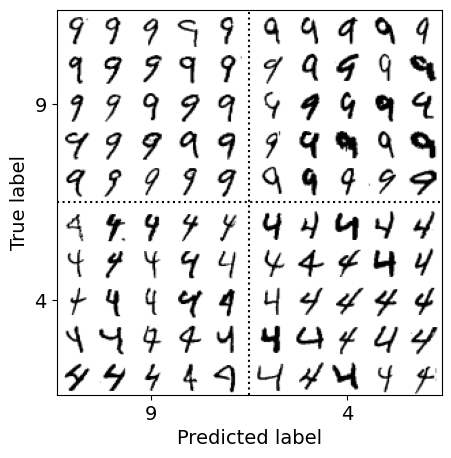

In [69]:
# extra code – this cell generates and saves Figure 3–11
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## __10-    Multilabel Classification:__

It is the classification where each input can belong to multiple classes at once. Some classifiers do natively supports multilabel classification like KneighboursClassifier. 

And some classifiers like SVC do not supports it.

In simple words, in multilabel classification Each input has more than one label (e.g., "odd", "large").


In [75]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

labels_train_large = (labels_train_data >= '7')
labels_train_odd = (labels_train_data.astype("int8")%2 == 1)

multilabels_train = np.c_[labels_train_large, labels_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(pixels_train_data, multilabels_train)

KNeighborsClassifier()

In [76]:
knn_clf.predict([some_digit])

array([[False, False]])

In [77]:
# We can evaluate a multilabel classifier in many ways like calculating f1_score
# The f1_score is calculated for each labels and then the result is the average of those

labels_train_knn_pred = cross_val_predict(knn_clf, pixels_train_data, multilabels_train, cv=3)

f1_score(multilabels_train, labels_train_knn_pred, average="macro")

0.976410265560605

In [78]:
# To use classifier that does not natively support multilabel classification we can 
#   train multiple models per label but if the labels are dependent it will do more computation then needed

# To fix this we can use ChainClassifier - it tells the models about the previous models predictions

from sklearn.multioutput import ClassifierChain

# SVC does not support multilabels so we are using ClassifierChain 
chain_clf = ClassifierChain(SVC(),cv=3, random_state=42 )
chain_clf.fit(pixels_train_data[:2000], multilabels_train[:2000])

chain_clf.predict([some_digit])

array([[0., 0.]])

## __11-   Multioutput Classification:__

In simple words, each can be a multiclass i.e., can have more than two values. For example a label of pixel ranges from 0-255 where each pixel can have any value between 0-225.

We can see multilabel classification by training a model to predict clear images(pixels) from
noisy images(pixels)

In [81]:
# So we first create a data of noisy images.
np.random.seed(42)

noise = np.random.randint(0, 100, (len(pixels_train_data), 784))
pixels_train_noised = pixels_train_data + noise

noise = np.random.randint(0, 100, (len(pixels_test_data), 784))
pixels_test_noised = pixels_test_data + noise

pixels_train_clear = pixels_train_data
pixels_test_clear = pixels_test_data

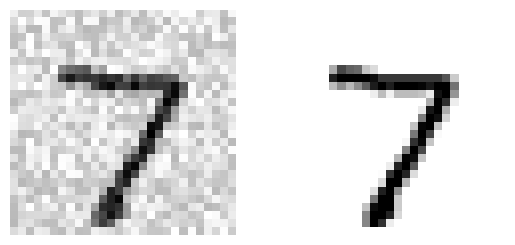

In [85]:
plt.subplot(121); plot_digit(pixels_test_noised[0])
plt.subplot(122); plot_digit(pixels_test_clear[0])
plt.show()

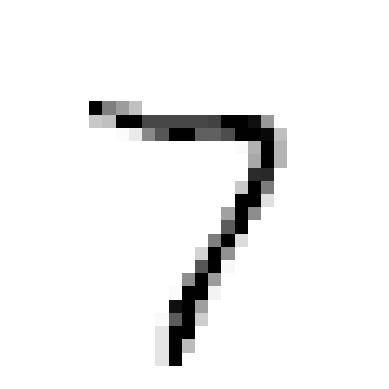

In [88]:
# Now we will train a model to clean a noisy image to a clear, this model will have 
#   multiple labels( pixel 1, .. .., pixel 764) and each label has multiple classes(0-255)

knn_clf = KNeighborsClassifier()
knn_clf.fit(pixels_train_noised, pixels_train_clear)

clean_digit = knn_clf.predict([pixels_test_noised[0]])
plot_digit(clean_digit)
plt.show()